In [1]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import tqdm.notebook
import time
from sklearn import preprocessing
import glob
from skimage.measure import block_reduce
import tqdm.notebook
from datetime import datetime
import gc

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('classic')
import src.utils
from src.utils import set_gpytorch_settings
set_gpytorch_settings(False)
# Kernel Imports
from gpytorch.kernels import PeriodicKernel
from src.custom_kernel import MinKernel, AR2Kernel, MaternKernel, LinearKernel
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.kernels.keops import MaternKernel as FastMaternKernel
from gpytorch.kernels.keops import RBFKernel as FastRBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval
# from gpytorch.metrics import mean_standardized_log_loss, quantile_coverage_error, mean_squared_error, mean_absolute_error
from src.custom_kernel import noise_lower, noise_upper, noise_init

['/home/dcaos/PycharmProjects/GaussProcesses/notebooks', '/home/dcaos/PycharmProjects/GaussProcesses', '/home/dcaos/anaconda3/lib/python310.zip', '/home/dcaos/anaconda3/lib/python3.10', '/home/dcaos/anaconda3/lib/python3.10/lib-dynload', '', '/home/dcaos/.local/lib/python3.10/site-packages', '/home/dcaos/anaconda3/lib/python3.10/site-packages', '/home/dcaos/anaconda3/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/dcaos/anaconda3/lib/python3.10/site-packages/mpmath-1.2.1-py3.10.egg', '/home/dcaos/.cache/keops2.1.2/Linux_endeavourDCAOS_6.2.11-arch1-1_p3.10.9', '/home/dcaos/PycharmProjects/GaussProcesses']


In [2]:
# Reading data file and cleaning missing values
df = pd.read_feather('../Data/feather/46221_9999_wave_height.feather')
parameters_wave = ['time', 'wave_height']
parameters_temp = ['time', 'sea_surface_temperature']
df_as_np = df \
    .loc[:, parameters_wave] \
    .astype(float) \
    .replace(to_replace = [999.0, 99.0, 9999.0], value = np.nan) \
    .to_numpy()
using_sk = block_reduce(df_as_np, block_size=(24,1), func=np.mean).astype(float)
X = torch.tensor(using_sk[:-1,0]).float().cuda()
y = torch.tensor(using_sk[:-1,1]).float().cuda()
X = X.reshape(-1,1)
y = y.reshape(-1,1)

X = X[~torch.any(y.isnan(), dim=1)]
y = y[~torch.any(y.isnan(), dim=1)]
y = y.flatten()
X_old = X


In [3]:
# Helper functions
def period_print(x, scale_factor_value):
    print(f"raw: {x}")
    print(f"seconds: {x * scale_factor_value}")
    print(f"minutes: {x * scale_factor_value / 60}")
    print(f"hours: {x * scale_factor_value / 60 / 60 }")
    print(f"days: {x * scale_factor_value / 60 / 60 / 24}")
    print(f"weeks: {x * scale_factor_value / 60 / 60 / 24 / 7}")
    print(f"months: {x * scale_factor_value / 60 / 60 / 24 / 30}")
    print(f"years: {x * scale_factor_value / 60 / 60 / 24 / 365}")

def period_convert(x, type_to_convert, scale_factor_val):
    match type_to_convert:
        case "raw":
            return x
        case "seconds":
            return x * scale_factor_val
        case "minutes":
            return x * scale_factor_val / 60
        case "hours":
            return x * scale_factor_val / 60 / 60
        case "days":
            return x * scale_factor_val / 60 / 60 / 24
        case "weeks":
            return x * scale_factor_val / 60 / 60 / 24 / 7
        case "months":
            return x * scale_factor_val / 60 / 60 / 24 / 30
        case "years":
            return x * scale_factor_val / 60 / 60 / 24 / 365

def period_convert_list(li, type_to_convert, scale_factor_val):
    converted_list = []
    for h in li:
        converted_list.append(period_convert(h, type_to_convert, scale_factor_val))
    return converted_list

def scaler(a, X_old=X_old, center=True):
    if center is True:
        a = a - X_old.min(0).values
    return a / (X_old.max(0).values - X_old.min(0).values)

def make_kernel(name_of_kernel):
    if name_of_kernel == 'RBF':
        return RBFKernel()
    elif name_of_kernel.startswith('Mat'):
        nu_value = float(name_of_kernel[-3:])
        return MaternKernel(nu=nu_value)
    elif name_of_kernel == 'AR2':
        return AR2Kernel(
            period_constraint=Interval(
                lower_bound=1e-4, upper_bound=0.005),
            lengthscale_constraint=Interval(
                lower_bound=1e-4, upper_bound=0.005))
    if name_of_kernel.startswith('Per'):
        if name_of_kernel == 'Per_Arb':
            return PeriodicKernel(
                period_length_constraint=Interval(
                    lower_bound=1e-4, upper_bound=0.75))
        elif name_of_kernel == 'Per_Week':
            return PeriodicKernel(
                period_length_constraint=Interval(
                    lower_bound=1e-4, upper_bound=0.75,
                initial_value=scaler(60*60*24*7, center=False)))
        elif name_of_kernel == 'Per_Month':
            return PeriodicKernel(
                period_length_constraint=Interval(
                    lower_bound=1e-4, upper_bound=0.75,
                initial_value=scaler(60*60*24*30, center=False)))
    else:
        raise ValueError('Kernel not found')

def descaler(a, X_old=X_old, center=True):
    if center is True:
        a = a * (X_old.max(0).values - X_old.min(0).values)
    return a + X_old.min(0).values

# GP Model Declaration
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



Scale Max: 1677108352.0
 Scale Min: 1349069952.0
 Scale Factor: 328038400.0
Before Block Reduce: (174818, 2)
After Block Reduce: (7285, 2)
Number of Nans: 0
Start Time: 2012-09-30 16:55:44
End Time: 2023-02-22 23:25:52
Number of Days: 3642.0416666666665
Time Period (Days): 3797.312592592593


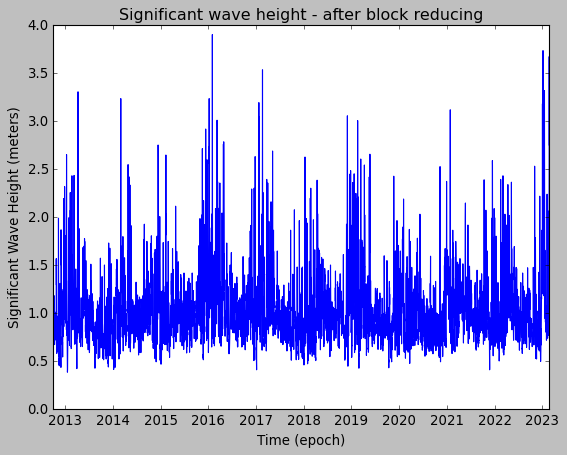

In [4]:
from numpy.ma import indices

# Scale the time axis and log transform the Y-values
X = scaler(X, X_old)
y = y.log()

# max, min, and scale factor declaration
scaler_max = X_old.max(0).values.item()
scaler_min = X_old.min(0).values.item()
scale_factor = scaler_max - scaler_min
print(f'Scale Max: {scaler_max}\n Scale Min: {scaler_min}\n Scale Factor: {scale_factor}')
temp_for_plotting = pd.Series(using_sk[:-1,0]*1e9, dtype='datetime64[ns]')
plt.plot(temp_for_plotting, using_sk[:-1,1])
# plt.plot(y.cpu().numpy())
# print(y)
plt.xlabel("Time (epoch)")
plt.ylabel("Significant Wave Height (meters)")
plt.title(f'Significant wave height - after block reducing')

print(
    f'Before Block Reduce: {df_as_np.shape}\n'
    f'After Block Reduce: {using_sk.shape}\n'
    f'Number of Nans: {np.count_nonzero(np.isnan(df_as_np))}\n'
    f'Start Time: {datetime.fromtimestamp(df_as_np[0,0])}\n'
    f'End Time: {datetime.fromtimestamp(df_as_np[-1,0])}\n'
    f'Number of Days: {df_as_np.shape[0]/48}\n'
    f'Time Period (Days): {(df_as_np[-1,0] - df_as_np[0,0]) / 24 / 60 / 60}')

# Prediction range, training and test set define
predict_days_out = 14
test_n = 2*predict_days_out
train_x = X[test_n:].contiguous().cuda()
train_y = y[test_n:].contiguous().cuda()
test_x = X[-test_n:].contiguous().cuda()
test_y = y[-test_n:].contiguous().cuda()

# Generate the train_loader and train_dataset
train_loader, train_dataset, test_loader, test_dataset = src.utils.create_train_loader_and_dataset(
    train_x, train_y, test_x, test_y)
data_compact = [train_x, train_y, test_x, test_y, train_loader, train_dataset, test_loader, test_dataset]

Using available CUDA


Training_exactGPRBFplusMat2.5plusPer_MonthplusRBFxPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

Kernel Structure:  RBF Mat2.5 Per_Month Per_Arb RBF
BIC:  -2178.580078125
Iterations Number:  0
Memory Check:  (914685952, 8353546240)


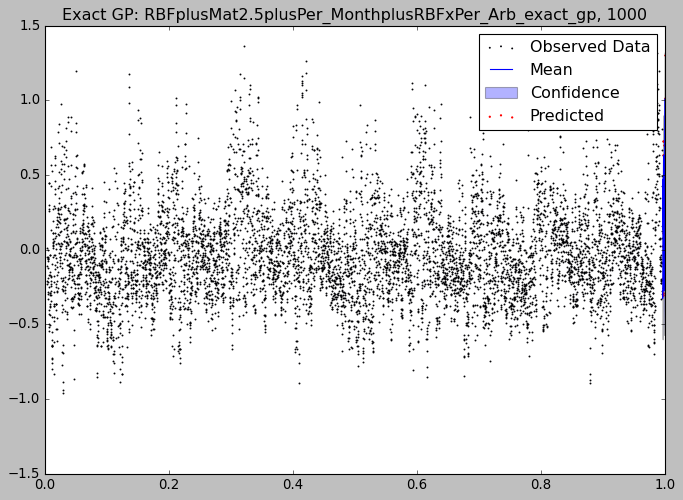

In [5]:
# List of possible Kernels terms
# Long-term dependence
smooth_kernel_list_t1 = ['RBF']#, 'Mat0.5', 'Mat1.5', 'Mat2.5']
# Medium-term dependence
smooth_kernel_list_t2 = ['Mat2.5']#, 'Mat2.5']#['RBF', 'Mat0.5', 'Mat1.5',
# Fixed Monthly Period
periodic_kernel_list_t3 = ['Per_Month']
# Cyclic period
smooth_kernel_list_t4 = ['RBF']#, 'Mat0.5', 'Mat1.5', 'Mat2.5']
periodic_kernel_list_t4 = ['Per_Arb']#['Per_Arb', 'Per_Week',


# Initializing empty list to record values
bic_save = []
index_checker = 0

for sk1 in smooth_kernel_list_t1:
    for sk2 in smooth_kernel_list_t2:
        for pk1 in periodic_kernel_list_t3:
            for sk3 in smooth_kernel_list_t4:
                for pk2 in periodic_kernel_list_t4:
                    kernel = ScaleKernel(make_kernel(sk1)) + ScaleKernel(make_kernel(sk2)) + ScaleKernel(make_kernel(pk1)) + ScaleKernel(make_kernel(pk2) * make_kernel(sk3))
                    kernel_name = f'{sk1}plus{sk2}plus{pk1}plus{sk3}x{pk2}_exact_gp'
                    k_list = [str(sk1), str(sk2), str(pk1), str(pk2), str(sk3)]
                    exact_gp = src.utils.TrainTestPlotSaveExactGP(
                        ExactGPModel, kernel,
                        train_x, train_y, test_x, test_y,
                        num_iter=1000, lr=0.0063,
                        name=kernel_name)
                    exact_gp.test_eval_exact_gp()
                    exact_gp.plot(show_plot=False)
                    bic_value = exact_gp.get_BIC()
                    hyper_values = [
                        kernel.kernels[0].base_kernel.lengthscale.item(),
                        kernel.kernels[1].base_kernel.lengthscale.item(),
                        kernel.kernels[2].base_kernel.lengthscale.item(),
                        kernel.kernels[2].base_kernel.period_length.item(),
                        kernel.kernels[3].base_kernel.kernels[0].lengthscale.item(),
                        kernel.kernels[3].base_kernel.kernels[0].period_length.item(),
                        kernel.kernels[3].base_kernel.kernels[1].lengthscale.item(),]
                    bic_save.append([
                        kernel_name,
                        bic_value.item(),
                        *period_convert_list(hyper_values, "days", scale_factor),
                        *hyper_values,
                        *k_list])
                    print("Kernel Structure: ", *k_list)
                    print("BIC: ", exact_gp.get_BIC().item())
                    print("Iterations Number: ",index_checker)
                    print("Memory Check: ", torch.cuda.mem_get_info(device=None))
                    index_checker += 1
                    del exact_gp
                    del kernel
                    gc.enable()
                    gc.collect()
                    torch.cuda.empty_cache()
bic_out_df = pd.DataFrame(
    bic_save, columns=[
        'Kernel Name', 'BIC',
        's1_ls_converted', 's2_ls_converted','pk1_ls_converted', 'pk1_pr_converted', 'pk2_ls_converted', 'pk2_pr_converted', 's3_ls_converted',
        's1_ls_raw', 's2_ls_raw', 'pk1_ls_raw', 'pk1_pr_raw', 'pk2_ls_raw', 'pk2_pr_raw','s3_ls_raw',
        'add_scale1_K1', 'add_scale2_K2', 'add_period1_K3', 'scale3_mult_K4', 'scale3_mult_K4'])
# bic_out_df.to_csv('bic_save_linear_kernel_struct_baseline.csv')

In [6]:
# print(len(bic_save[0]))
# bic_save
# gc.enable()
# gc.collect()
# torch.cuda.empty_cache()
# torch.cuda.CUDAGraph().pool()

baseline_df_master = pd.read_csv('Baseline_Kernel_Results.csv', index_col='BIC')
baseline_df_master.to_csv('Baseline_Kernel_Results_bak.csv')
# baseline_df_master = baseline_df_master.reset_index()
baseline_df_master
bic_out_df
# joined_baseline_df = pd.merge(right=baseline_df_master, left=bic_out_df, on='BIC', how='outer')
# pd.concat([baseline_df_master, bic_out_df], ignore_index=True)
# joined_baseline_df.to_csv('Baseline_Kernel_Results.csv')
# joined_baseline_df
# temp_list = []
# temp_list.append([*period_convert_list(hyper_values, "days", scale_factor)])
# temp_list

,Kernel Name,BIC,s1_ls_converted,s2_ls_converted,pk1_ls_converted,pk1_pr_converted,pk2_ls_converted,pk2_pr_converted,s3_ls_converted,s1_ls_raw,...,pk1_ls_raw,pk1_pr_raw,pk2_ls_raw,pk2_pr_raw,s3_ls_raw,add_scale1_K1,add_scale2_K2,add_period1_K3,scale3_mult_K4,scale3_mult_K4
0,RBFplusMat2.5plusPer_MonthplusRBFxPer_Arb_exac...,-2178.580078,13081.849969,10709.527897,11335.792638,30.758205,0.177548,1104.764009,431.183474,3.445547,...,2.985664,0.008101,0.000047,0.290977,0.113567,RBF,Mat2.5,Per_Month,Per_Arb,RBF
